In [1841]:
import pandas as pd
import matplotlib.pyplot as plt
from tdmsdata import TdmsData
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import doppler_shift
import importlib


In [1842]:
# inputs
file = '20231124_0955_Sn_118_res_scan.tdms'
channel = 1
isotope = 118

In [1843]:
# Function to read TDMS file and extract raw data
def read_tdms(file, channel):
    TDMS = TdmsData(''.join(['/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/Isotope shift/{}'.format(file)]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array
    return raw_data

In [1844]:
# Function to create a dataset from raw data
def create_df(raw_data):
    return pd.DataFrame({'Cycle': raw_data[:, 0], 'Time(sec)': raw_data[:, 1], 'Wavelength (nm)': raw_data[:, 2]})

In [1845]:
def doppler_shift_calc(dataset):
    importlib.reload(doppler_shift)

    # Copying the original dataframe to avoid modifying it directly
    doppler_df = dataset.copy()

    # Get the original wavelengths from the dataframe 
    wavelengths = doppler_df['Wavelength (nm)']

    # Apply the Doppler shift to the wavelengths
    shifted_wls = doppler_shift.getshift(wavelengths, isotope)

    # Add the shifted wavelengths as a new column to the copied dataframe
    doppler_df['Wavelength (nm)'] = shifted_wls

    return doppler_df

In [1846]:
def process_tdms(raw_df, bins):
    # Extract wavelengths and compute counts
    wavelengths_raw = raw_df['Wavelength (nm)']
    counts_df = wavelengths_raw.value_counts().reset_index()
    counts_df.columns = ['Wavelength', 'Count']

    # Skip the first row if needed
    counts_df = counts_df.iloc[1:].reset_index(drop=True)

    # Create bins and compute binned counts
    counts_df['Wavelength bin'] = pd.cut(counts_df['Wavelength'], bins)
    binned_counts_df = counts_df.groupby('Wavelength bin', observed=False)['Count'].sum().reset_index()

    # Compute bin midpoints
    binned_counts_df['Bin center'] = binned_counts_df['Wavelength bin'].apply(lambda x: x.mid)

    return counts_df, binned_counts_df 

In [ ]:
def nm_to_MHz():
    return

In [1847]:
def get_peak_info(wavelengths, counts):
    if isinstance(wavelengths, pd.Index):
        wavelengths = pd.Series(wavelengths)
    
    max_count_index = counts.idxmax()
    max_wavelength = wavelengths.iloc[max_count_index]
    max_count = counts.iloc[max_count_index]

    # Calculate half maximum
    half_max_count = max_count / 2

    # Find wavelengths where count crosses the half maximum
    idx_below_half_max = counts >= half_max_count

    wavelengths_below_half_max = wavelengths[idx_below_half_max]

    left_bound = wavelengths_below_half_max.min()
    right_bound = wavelengths_below_half_max.max()

    fwhm = right_bound - left_bound

    return max_wavelength, fwhm

In [1848]:
def get_scatter_plot(wavelengths, counts):
    plt.scatter(wavelengths, counts)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Count')
    plt.title(f'{file[14:20]} raw data')
    plt.show()

    max_wl, fwhm = get_peak_info(wavelengths, counts)
    print(f'Peak WL: {max_wl} nm, FWHM: {fwhm}')


In [1849]:
def plot_kde(wavelengths, counts, bins):
    kde = gaussian_kde(wavelengths, weights=counts, bw_method=0.1)
    wavelength_range = np.linspace(wavelengths.min(), wavelengths.max(), 1000)
    kde_values = kde(wavelength_range)

    plt.plot(wavelength_range, kde_values)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Density')
    plt.title(f'{file[14:20]} Gaussian KDE, bins={bins}')
    plt.show()

    max_wl, fwhm = get_peak_info(pd.Series(wavelength_range), pd.Series(kde_values))
    print(f'Peak WL: {max_wl} nm, FWHM: {fwhm}')


In [1850]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [1851]:
def gaussian_exponential(x, A, mu, sigma, tau, bkg):
    # gaussian_part = gaussian(x, A, mu, sigma)
    # exponential = B * np.exp(x * -tau)

    # # transition = np.heaviside(x - transition_point, 0)
    # transition = 1 / (1 + np.exp(-(x - transition_point) / width)) # logistic function
    # # print(transition)
    # gaus = gaussian_part * (1 - transition)
    # exp = exponential * transition
    # test =  gaus+ exp
    # # print(gaus)
    # # print(exp)
    # exponential = B * np.exp(-(x - mu) / tau) + bkg
    
    # # Combine the two components using an error function
    # asymmetry = 0.5 * (1 - erfc((x - mu) / (np.sqrt(2) * sigma))) 
    
    # return gaussian(x, A, mu, sigma) * asymmetry + exponential * (1 - asymmetry) 
    exp_tail = A * np.exp(-(x - mu) / tau) * (x > mu)
    
    return gaussian(x,A,mu,sigma) + exp_tail * np.exp(-(mu - x)**2 / (2 * sigma**2)) + bkg


    # return test

In [1852]:
from scipy.special import voigt_profile

def asymmetric_fit(x, A, mu, sigma, gamma, tau, bkg, trans_width):
    voigt = A * voigt_profile(x - mu, sigma, gamma)
    exponential = A * np.exp(-(x - mu) / tau) * (x > mu)

    transition = 1 / (1 + np.exp(-(x - mu) / trans_width))
    
    return (1 - transition) * voigt + transition * exponential + bkg

    # return voigt + exponential * np.exp(-(mu - x)**2 / (2 * sigma**2)) + bkg

In [1853]:
def fitting(wavelengths, counts, bins):
    peak_wl, _ = get_peak_info(wavelengths, counts)
    peak_width = (max(wavelengths) - min(wavelengths)) / 20

    initial_guess_gaus = [np.max(counts), peak_wl, np.std(wavelengths)]
    # initial_guess_asym = [np.max(counts), peak_wl, np.std(wavelengths), peak_width, 100, min(counts), 0.1]

    params_gaus, _ = curve_fit(gaussian, wavelengths, counts, p0=initial_guess_gaus)
    # params_asym, _ = curve_fit(asymmetric_fit, wavelengths, counts, p0=initial_guess_asym)

    x_fit = np.linspace(min(wavelengths), max(wavelengths), 1000)

    y_fit_gaus = gaussian(x_fit, *params_gaus)
    # y_fit_asym = asymmetric_fit(x_fit, *params_asym)

    y_errors = np.sqrt(counts)

    plt.errorbar(wavelengths, counts, yerr=y_errors, fmt='o',capsize=5, elinewidth=2, markersize=5)
    plt.plot(x_fit, y_fit_gaus, color='red', label='Gaussian')
    # plt.plot(x_fit, y_fit_asym, color='blue', label='Gaussian + Exponential')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Count')
    plt.title(f'{file[14:20]} fitting, bins={bins}')
    plt.legend()
    plt.show()

    print(f'GAUSSIAN Peak: {params_gaus[1]}, FWHM: {2 * np.sqrt(2 * np.log(2)) * params_gaus[2]}')
    # print(f'Combined Peak: {params_gaus[1]}, FWHM: {2 * np.sqrt(2 * np.log(2)) * params_gaus[2]}')

In [1854]:
# raw_data = read_tdms(file, channel)
# raw_df = create_df(raw_data)

# bins = 50
# counts_df, binned_counts_df = process_tdms(raw_df, bins)

# wavelengths = counts_df['Wavelength']
# counts = counts_df['Count']
# bin_center = binned_counts_df['Bin center'].cat.categories.astype(float)
# binned_counts = binned_counts_df['Count']
# # get_scatter_plot(wavelengths, counts)
# # get_scatter_plot(bin_center, binned_counts)
# gaussian_fit(bin_center, binned_counts, bins, file)


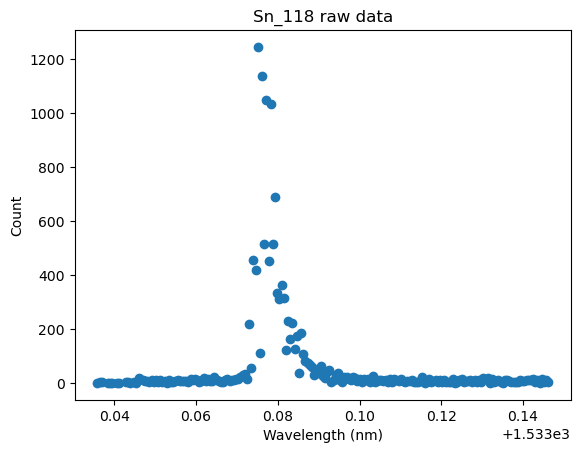

Peak WL: 1533.0750867306576 nm, FWHM: 0.004245481482939795


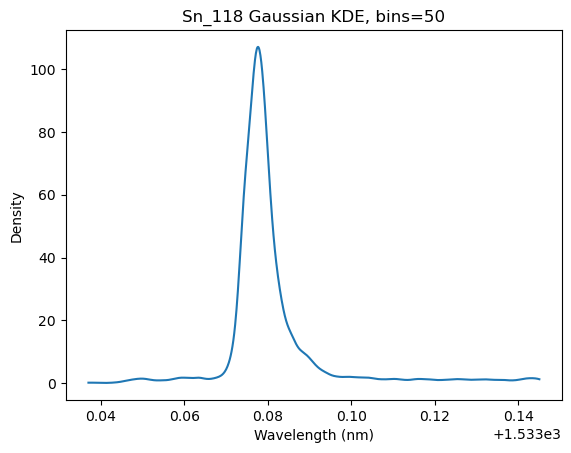

Peak WL: 1533.0776486486486 nm, FWHM: 0.006918918918927375


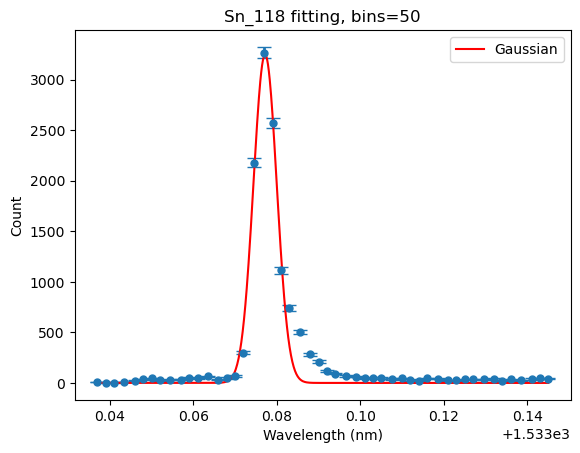

GAUSSIAN Peak: 1533.0771843731163, FWHM: 0.006563825741752227


In [1855]:
# Doppler correction 
raw_data = read_tdms(file, channel)
raw_df = create_df(raw_data)
doppler_df = doppler_shift_calc(raw_df)

bins = 50
counts_df, binned_counts_df = process_tdms(doppler_df, bins)

wavelengths = counts_df['Wavelength']
counts = counts_df['Count']
bin_center = binned_counts_df['Bin center'].cat.categories.astype(float)
binned_counts = binned_counts_df['Count']
get_scatter_plot(wavelengths, counts)
# get_scatter_plot(bin_center, binned_counts)
plot_kde(bin_center, binned_counts, bins)
fitting(bin_center, binned_counts, bins)
